### Importamos nuestra librerías

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn import metrics

### Importamos las funciones

In [2]:
import sys
sys.path.insert(1, '..')
from utils import functions as func

### Importamos nuestros datasets que contienen los datos de Transfermarkt de tres temporadas desde 2017 a 2020

In [3]:
data_merc_1 = func.load_dataset(path = r'data\raw/jugadores_201718.csv',
                                separador=';',
                                codif='utf-8')
data_merc_2 = func.load_dataset(path = r'data\raw/jugadores_201819.csv',
                                separador=';',
                                codif='utf-8')      
data_merc_3 = func.load_dataset(path = r'data\raw/jugadores_201920.csv',
                                separador=';',
                                codif='utf-8')                                                             

C:\Users\Jesús\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:6: DtypeWarning: Columns (395) have mixed types.Specify dtype option on import or set low_memory=False.
  


### Unimos nuestros datasets

In [4]:
all_dfs = [data_merc_1, data_merc_2, data_merc_3]
data_merc = pd.concat(all_dfs).reset_index(drop=True)

### Guardamos los nombres de nuestras columnas en un dataframe y luego lo exportamos a csv

In [5]:
nombres_columnas = data_merc.columns
dataframe_columnas = pd.DataFrame({'Nombres':nombres_columnas})
func.save_dataset(data = dataframe_columnas, path = "D:\Jesus\BootCampThe_Bridge\Clases\Alumno\Entregables\Proyecto_ML\src\data\processed/nombres_columnas.csv", separador = ';')

### Queremos procesar la columna de los equipos y para ello vamos a analizar estos por la cantidad de goles totales en un dataframe aparte

In [6]:
#Creamos nuestro dataframe con los equipos
data_squad = data_merc[['squad','goals']]

In [7]:
#Comprobamos que existen valores nulos
data_squad[data_squad.isna().any(axis=1)]

,squad,goals
4332,NaN,NaN
4333,NaN,NaN
4334,NaN,NaN
4335,NaN,NaN
4336,NaN,NaN
...,...,...
4459,NaN,NaN
4460,NaN,NaN
4461,NaN,NaN
4462,NaN,NaN


In [8]:
#Eliminamos las filas con valores nuevos
data_squad.dropna(inplace=True)

C:\Users\Jesús\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


#### Observamos que los nombres de algunos equipos contienen caracteres extraños. vamos a sustituirlos.

In [9]:
#Creamos un diccionario con estos nombres con caracteres erróneos y sus nombres correctos
dict_nombres = {'AtlĂ©tico Madrid':'Atlético Madrid', 'AlavĂ©s':'Alavés','KĂ¶ln':'Köln','LeganĂ©s':'Leganés','DĂĽsseldorf':'Düsseldorf','NĂ®mes':'Nîmes','Saint-Ă‰tienne':'Saint-Étienne'}

In [10]:
#Remplazamos los nombres
data_squad = func.cambia_valores(data = data_squad, nombre_columna = 'squad', dicc_valores= dict_nombres)

#### Agrupamos nuestros datos por equipos

In [11]:
data_squad_agrup = data_squad.groupby('squad').sum()
data_squad_agrup.reset_index(inplace= True)
data_squad_agrup

,squad,goals
0,Alavés,104.0
1,Amiens,91.0
2,Angers,106.0
3,Arsenal,195.0
4,Aston Villa,40.0
...,...,...
117,Werder Bremen,115.0
118,West Brom,22.0
119,West Ham,111.0
120,Wolfsburg,130.0


#### Por último, creamos un diccionario con nuestros nombres de equipos y un valor del 1 al 8 que aumentará en función de la cantidad de goles que tengan registrados

In [12]:
dict_equip = {}
for pos, value in enumerate(data_squad_agrup['goals']):
    if value <= data_squad_agrup['goals'].quantile(0.15):
        dict_equip[data_squad_agrup['squad'][pos]] = 1
    elif 0.15 < value <= data_squad_agrup['goals'].quantile(0.25):
        dict_equip[data_squad_agrup['squad'][pos]] = 2
    elif 0.25 < value <= data_squad_agrup['goals'].quantile(0.35):
        dict_equip[data_squad_agrup['squad'][pos]] = 3
    elif 0.35 < value <= data_squad_agrup['goals'].quantile(0.5):
        dict_equip[data_squad_agrup['squad'][pos]] = 4            
    elif 0.5 < value <= data_squad_agrup['goals'].quantile(0.65):
        dict_equip[data_squad_agrup['squad'][pos]] = 5
    elif 0.65 < value <= data_squad_agrup['goals'].quantile(0.75):
        dict_equip[data_squad_agrup['squad'][pos]] = 6
    elif 0.75 < value <= data_squad_agrup['goals'].quantile(0.85):
        dict_equip[data_squad_agrup['squad'][pos]] = 7        
    else:
        dict_equip[data_squad_agrup['squad'][pos]] = 8 

### Comenzamos a trabajar con los datos de los jugadores

#### Creamos nuestro dataframe con las columnas que consideramos que pueden ser útiles

In [13]:
data_jug = data_merc[['player','position','squad', 'games', 'games_starts', 'minutes','shots_total','xg_per90','passes_into_final_third','shots_on_target', 'goals_per_shot','dribbles_completed','passes_received','goals']]

In [14]:
#Eliminamos los valores nulos
data_jug.dropna(inplace= True)

C:\Users\Jesús\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


#### Los datos de los porteros no me interesan por lo que los eliminaremos

In [15]:
porteros = data_jug[data_jug['position'].str.contains('GK')]
data_jug.drop(porteros.index, axis = 0, inplace = True)

C:\Users\Jesús\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\frame.py:4908: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#### Sustituimos los nombres de equipos por los valores asignados en el diccionario. Antes tendremos que cambiar los nombres con caracteres raros.

In [16]:
data_jug = func.cambia_valores(data = data_jug, nombre_columna = 'squad', dicc_valores= dict_nombres)
data_jug = func.cambia_valores(data = data_jug, nombre_columna = 'squad', dicc_valores= dict_equip)

#### Creamos un diccionario con las posiciones y les asignamos valores. Remplazamos las posiciones por estos valores

In [17]:
dict_pos = {'DF,MF' : 1, 'MF,DF' : 2,'DF':3,'DF,FW' :4,'FW,DF': 5, 'MF': 6, 'MF,FW': 7, 'FW,MF': 8,'FW' : 9}
data_jug = func.cambia_valores(data = data_jug, nombre_columna = 'position', dicc_valores= dict_pos)

In [18]:
data_jug

,player,position,squad,games,games_starts,minutes,shots_total,xg_per90,passes_into_final_third,shots_on_target,goals_per_shot,dribbles_completed,passes_received,goals
0,Burgui,8,4,23.0,12.0,1037.0,14.0,0.08,28.0,4.0,0.07,24.0,345.0,1.0
1,Raphaël Varane,3,8,27.0,27.0,2320.0,10.0,0.04,82.0,2.0,0.00,10.0,973.0,0.0
2,Rubén Duarte,3,4,24.0,24.0,2138.0,8.0,0.02,41.0,1.0,0.00,11.0,463.0,0.0
3,Samuel Umtiti,3,8,25.0,24.0,2189.0,11.0,0.05,118.0,6.0,0.09,6.0,1251.0,1.0
4,Manu García,6,4,30.0,27.0,2438.0,26.0,0.11,92.0,8.0,0.12,17.0,732.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7103,Daniel Podence,8,4,9.0,3.0,289.0,10.0,0.49,3.0,4.0,0.10,9.0,117.0,1.0
7104,Romain SaĂŻss,3,4,33.0,31.0,2705.0,23.0,0.09,119.0,8.0,0.09,7.0,1165.0,2.0
7105,Adama TraorĂ©,8,4,37.0,27.0,2605.0,17.0,0.12,40.0,4.0,0.06,156.0,1045.0,4.0
7106,JesĂşs Vallejo,3,4,2.0,1.0,163.0,0.0,0.00,7.0,0.0,0.00,1.0,83.0,0.0


#### Calculo variables que puedan ser más "lógicas" para mi modelo.

In [19]:
data_jug['shoots_on_t_x_game'] = data_jug['shots_on_target']/data_jug['games']
data_jug['dribbles_x_game'] = data_jug['dribbles_completed']/data_jug['games']
data_jug['passes_x_game'] = data_jug['passes_into_final_third']/data_jug['games']

#### Finalmente obtengo mi dataframe

In [20]:
data_player = data_jug[['position','squad','minutes','xg_per90','shoots_on_t_x_game','passes_x_game','dribbles_x_game','goals']]

In [21]:
data_player = data_player.astype({'position':'int64'})

In [22]:
data_player.dtypes

position                int64
squad                   int64
minutes               float64
xg_per90              float64
shoots_on_t_x_game    float64
passes_x_game         float64
dribbles_x_game       float64
goals                 float64
dtype: object

#### Muestro las correlaciones

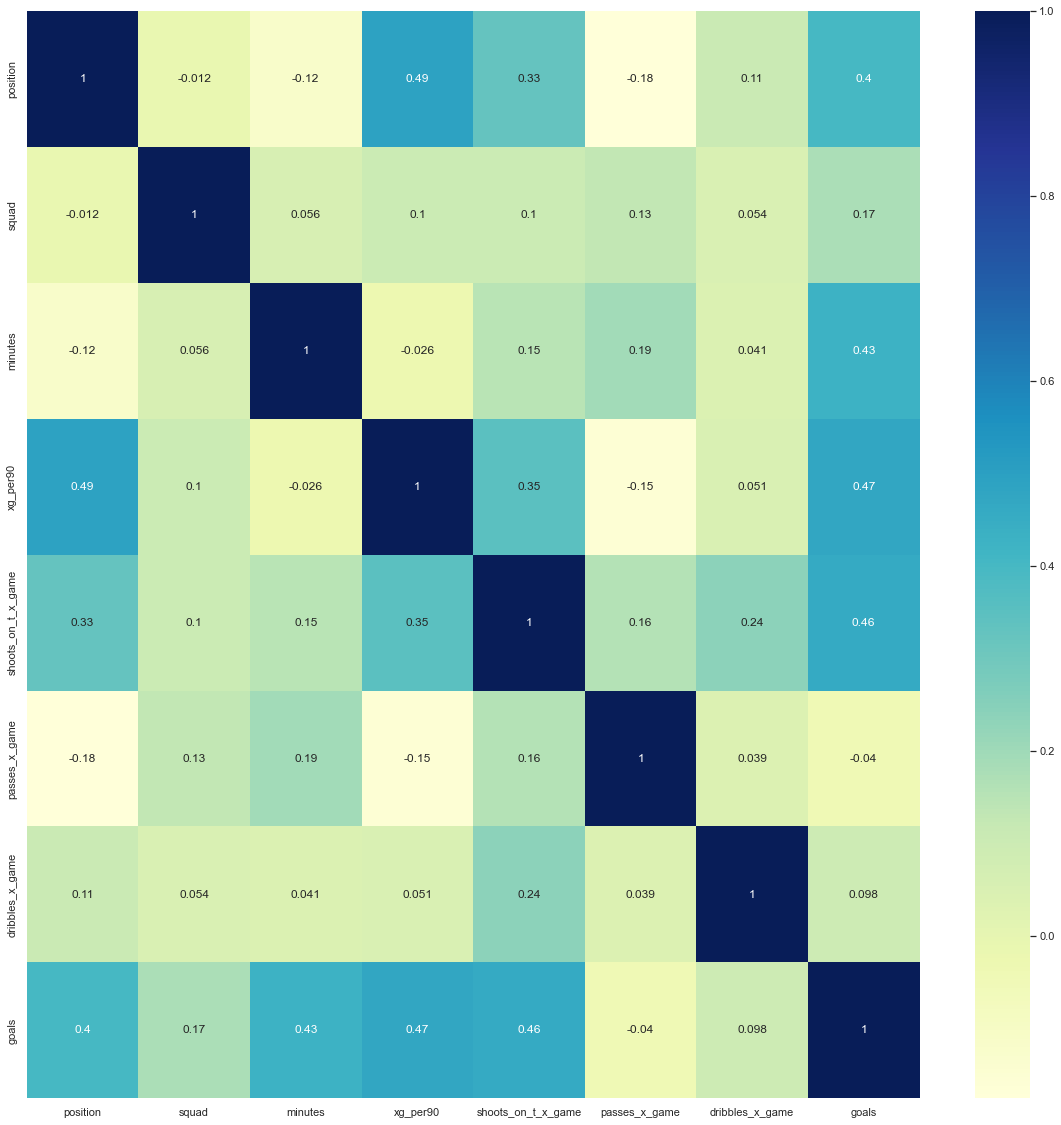

In [44]:
plt.figure(figsize = (20,20))
sns.heatmap(data_player.corr(),cmap = 'YlGnBu', annot = True)
plt.savefig("D:\Jesus\BootCampThe_Bridge\Clases\Alumno\Entregables\Proyecto_ML\src\data\images/correlaciones_variables.jpg")


In [24]:
data_player.to_csv("D:\Jesus\BootCampThe_Bridge\Clases\Alumno\Entregables\Proyecto_ML\src\data\processed\Datos_Clasif.csv", sep = ';')

#### Mostramos un pairplot

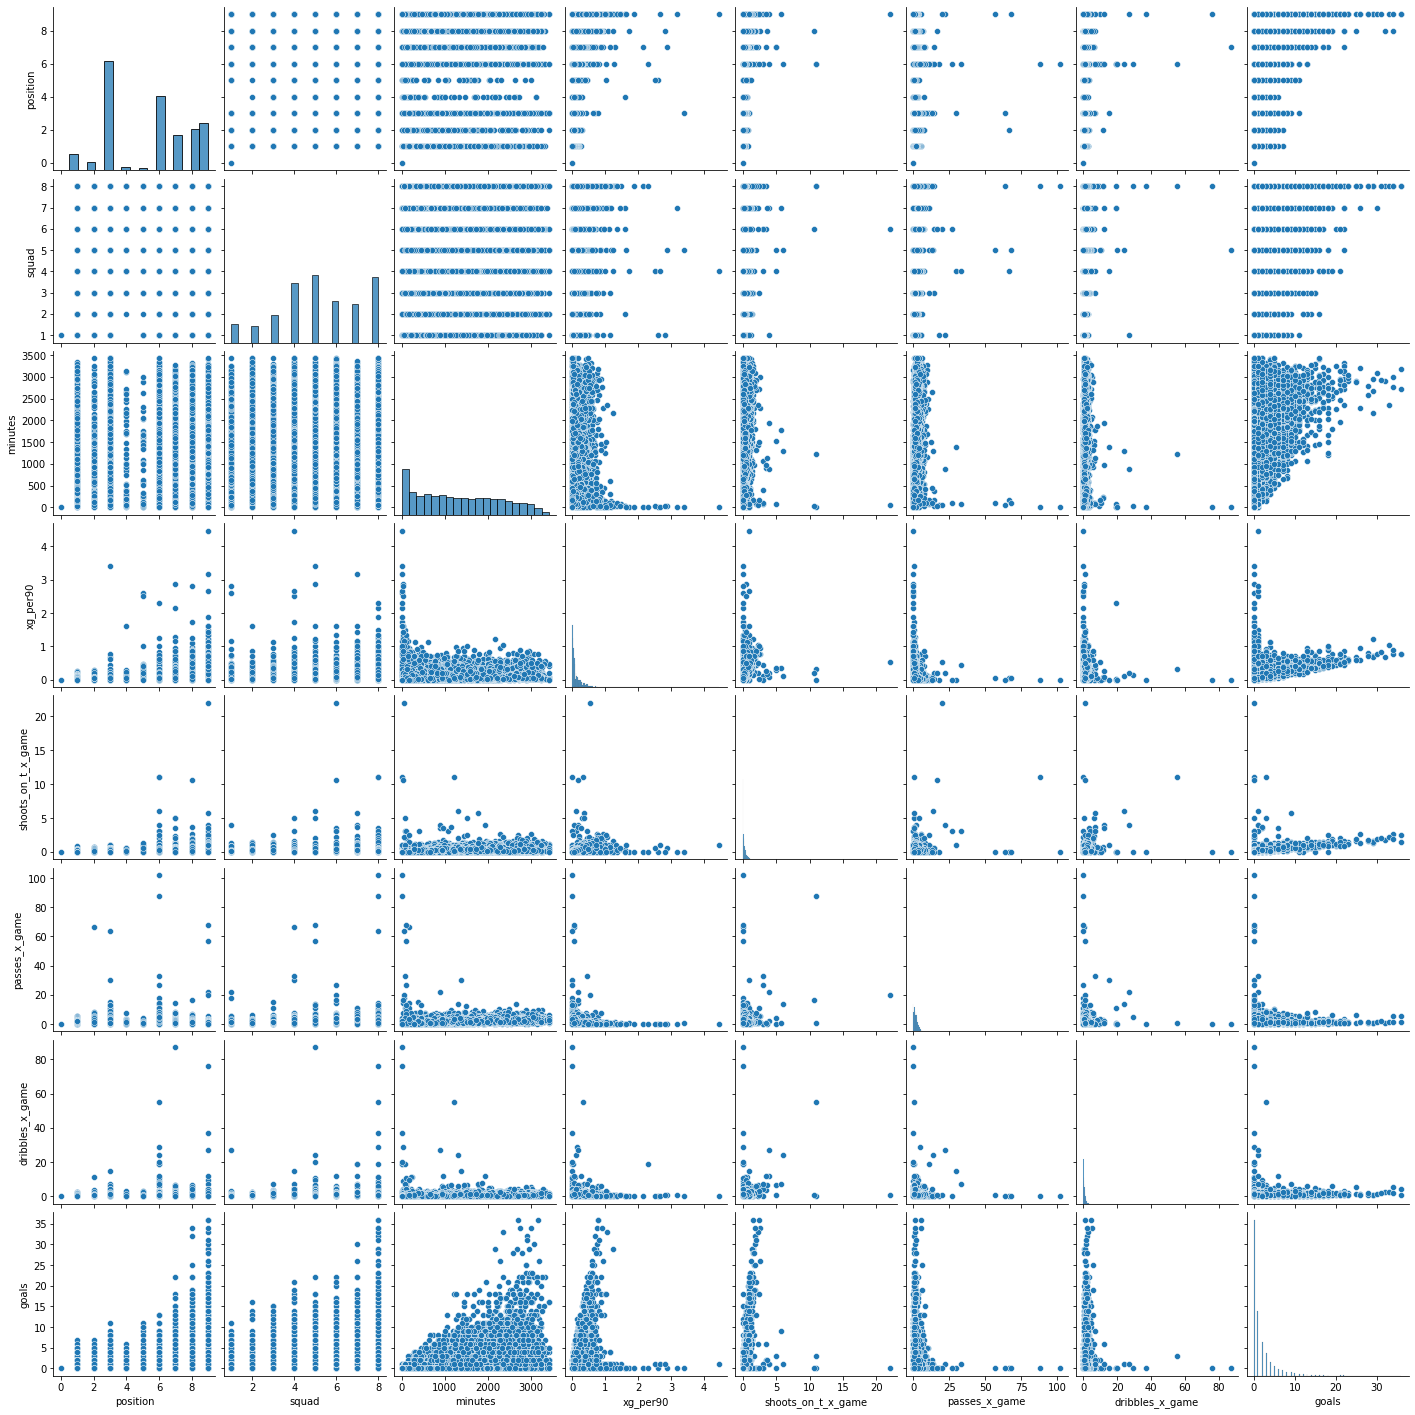

In [25]:
sns.pairplot(data_player);
plt.savefig("D:\Jesus\BootCampThe_Bridge\Clases\Alumno\Entregables\Proyecto_ML\src\data\images/pairplot_variables.jpg")

#### Vemos que nuestras variables no tienen una distribución normal. Guardaremos los datos normalizados para hacer pruebas con ellos también.

In [26]:
data_player_norm = data_player.copy()


In [27]:
for name in data_player.columns:
    data_player_norm[name] = np.log(data_player_norm[name]+1)

#### Mostramos pairplot de nuestro dataframe normalizado

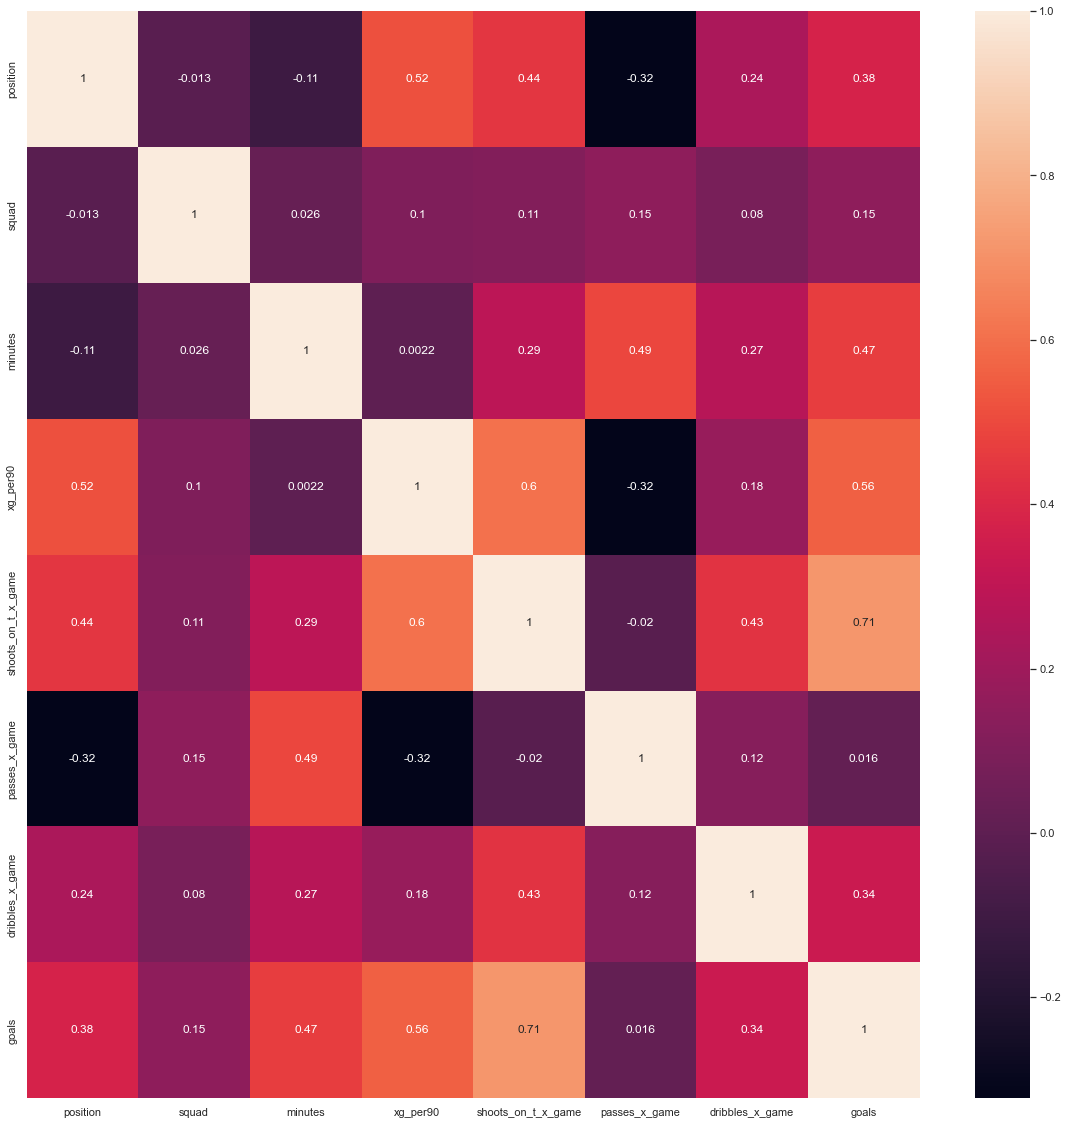

In [42]:
plt.figure(figsize = (20,20))
sns.heatmap(data_player_norm.corr(),cbar = 'YlGnBu', annot = True)
plt.savefig("D:\Jesus\BootCampThe_Bridge\Clases\Alumno\Entregables\Proyecto_ML\src\data\images/correlaciones_variables_normalizadas.jpg")

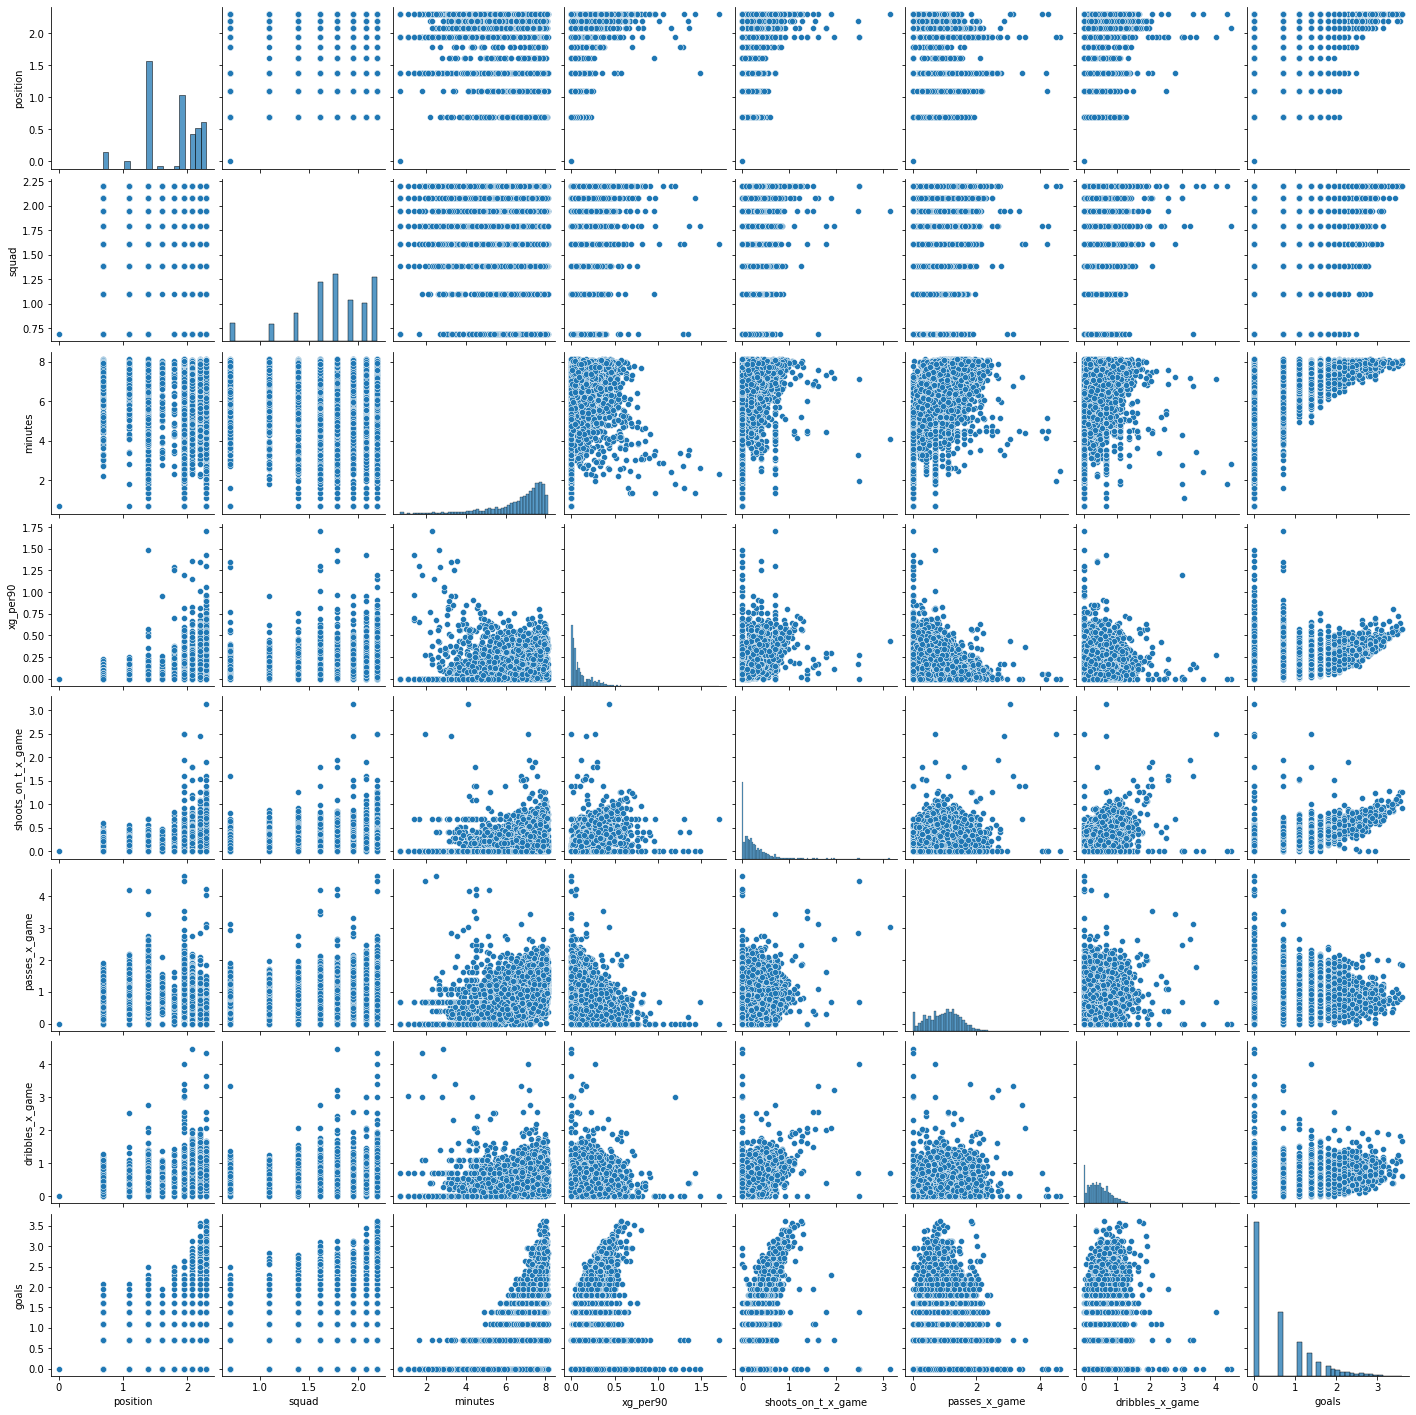

In [29]:
sns.pairplot(data_player_norm);
plt.savefig("D:\Jesus\BootCampThe_Bridge\Clases\Alumno\Entregables\Proyecto_ML\src\data\images/pairplot_variables_nomralizadas.jpg")

#### También crearemos dataframes nuevos en los que solo dejaremos las columnas que tienen una mayor correlación con nuestra variable target.

In [30]:
data_alta_corr = data_player.drop(['passes_x_game','dribbles_x_game','squad'], axis = 'columns')

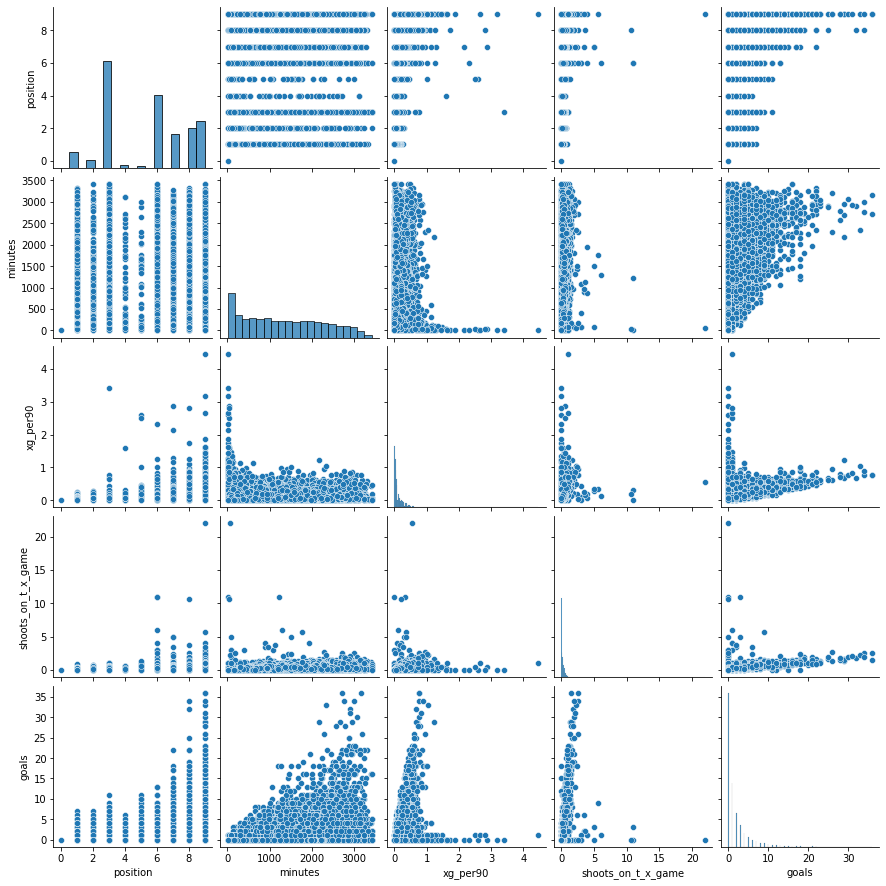

In [31]:
sns.pairplot(data_alta_corr);
plt.savefig("D:\Jesus\BootCampThe_Bridge\Clases\Alumno\Entregables\Proyecto_ML\src\data\images/pairplot_alta_corr.jpg")

In [32]:
sns.set_theme()

C:\Users\Jesús\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


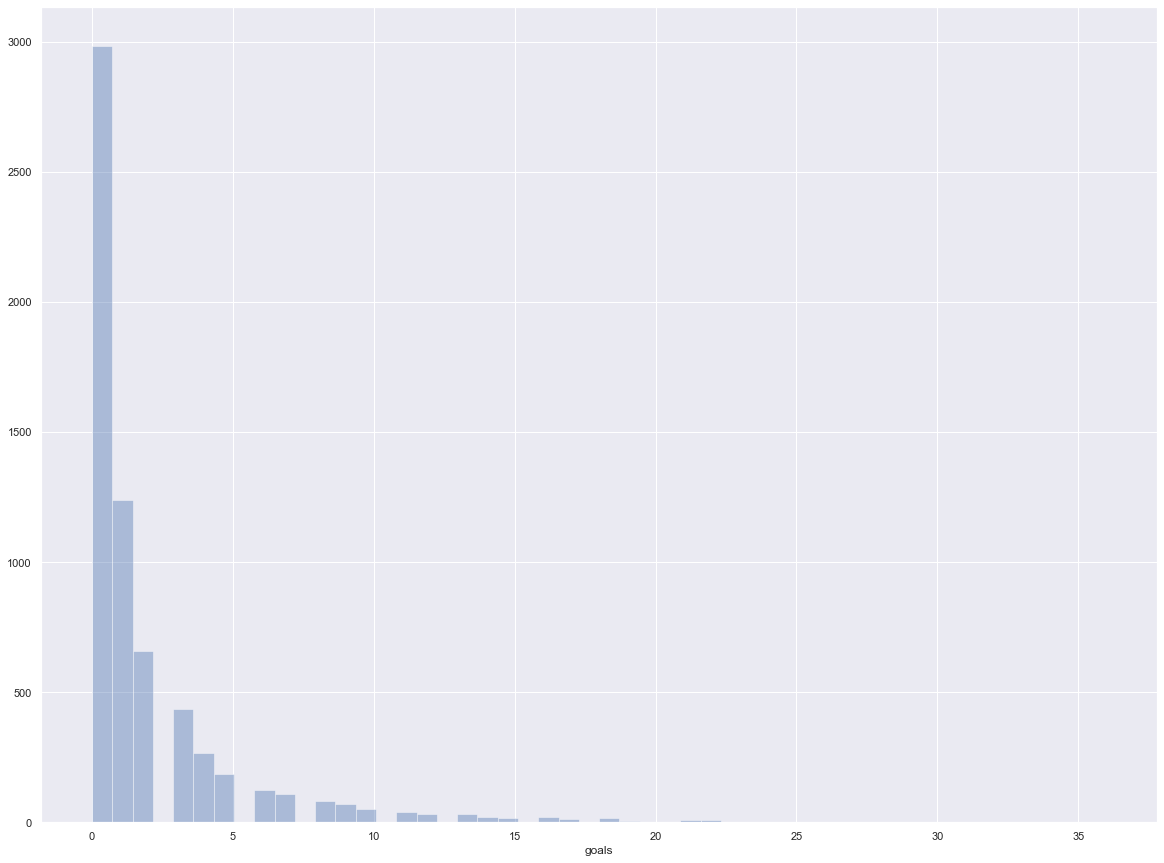

In [33]:
plt.figure(figsize=(20,15))
sns.distplot(data_alta_corr['goals'], kde = False)

plt.savefig("D:\Jesus\BootCampThe_Bridge\Clases\Alumno\Entregables\Proyecto_ML\src\data\images/dist_goles.jpg")

C:\Users\Jesús\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


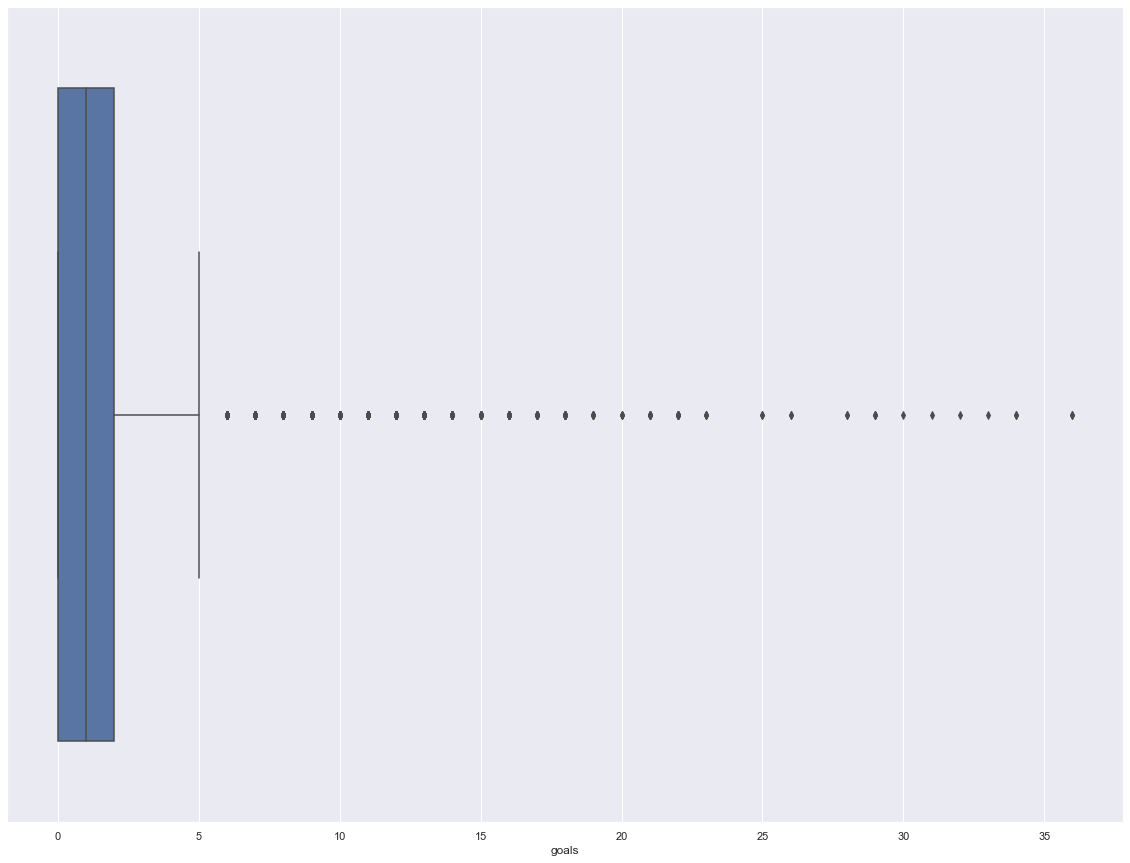

In [34]:
plt.figure(figsize=(20,15))
sns.boxplot(data_alta_corr['goals'])
plt.savefig("D:\Jesus\BootCampThe_Bridge\Clases\Alumno\Entregables\Proyecto_ML\src\data\images/box_plot_goles.jpg")

C:\Users\Jesús\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


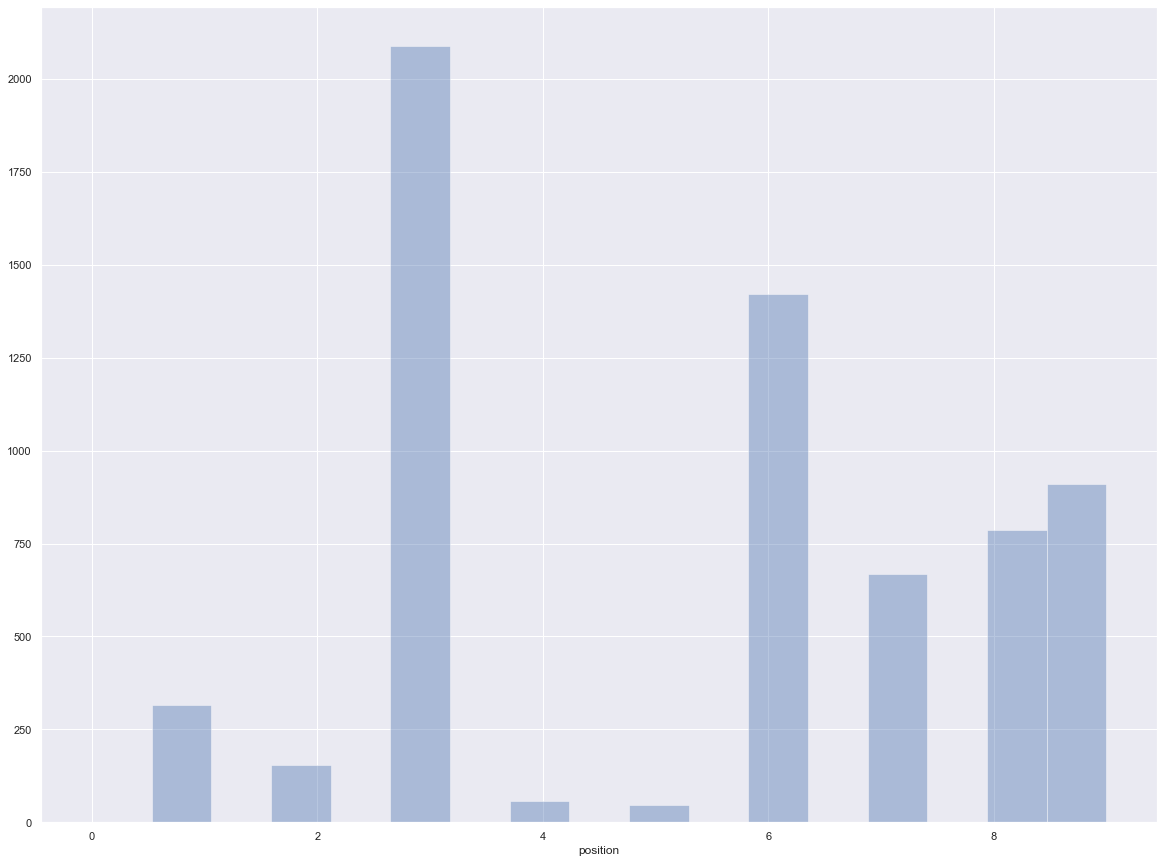

In [35]:
plt.figure(figsize=(20,15))
sns.distplot(data_alta_corr['position'], kde = False)

plt.savefig("D:\Jesus\BootCampThe_Bridge\Clases\Alumno\Entregables\Proyecto_ML\src\data\images/dist_position.jpg")

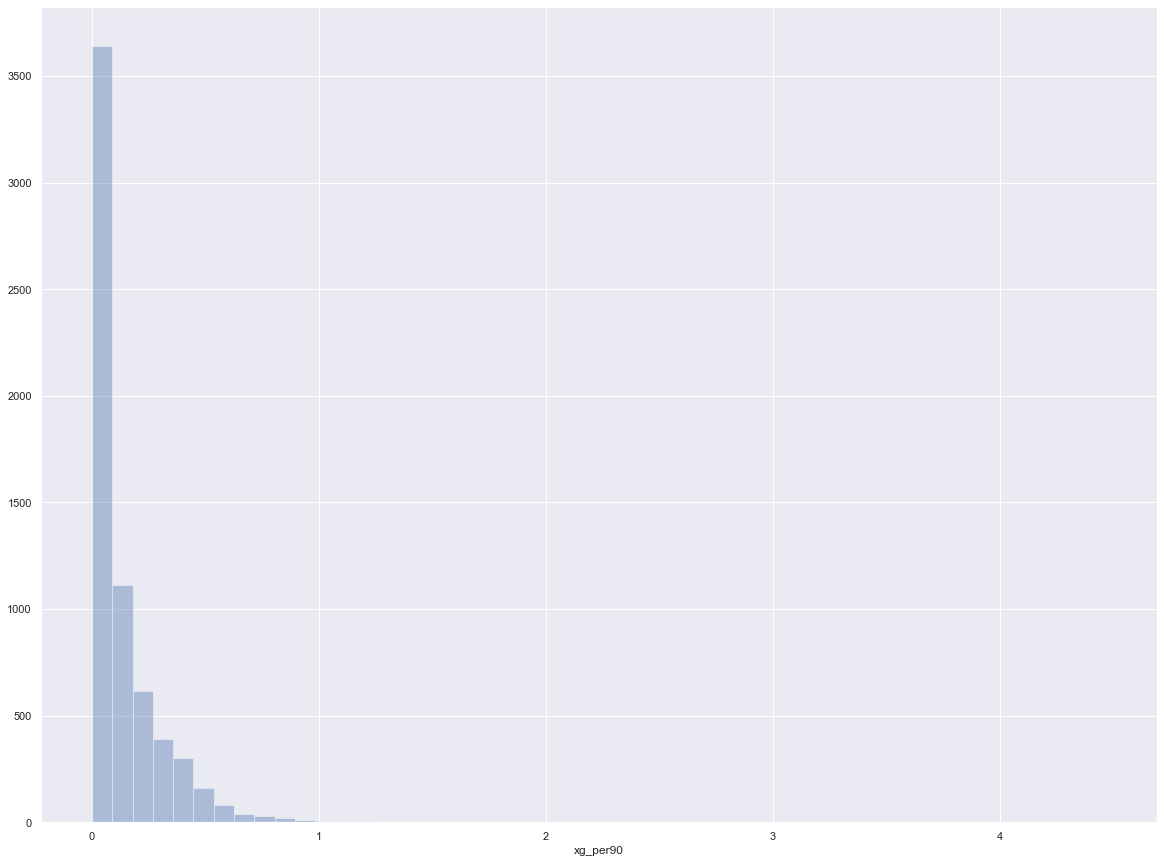

In [36]:
plt.figure(figsize=(20,15))
sns.distplot(data_alta_corr['xg_per90'], kde = False)

plt.savefig("D:\Jesus\BootCampThe_Bridge\Clases\Alumno\Entregables\Proyecto_ML\src\data\images/dist_xg_per90.jpg")

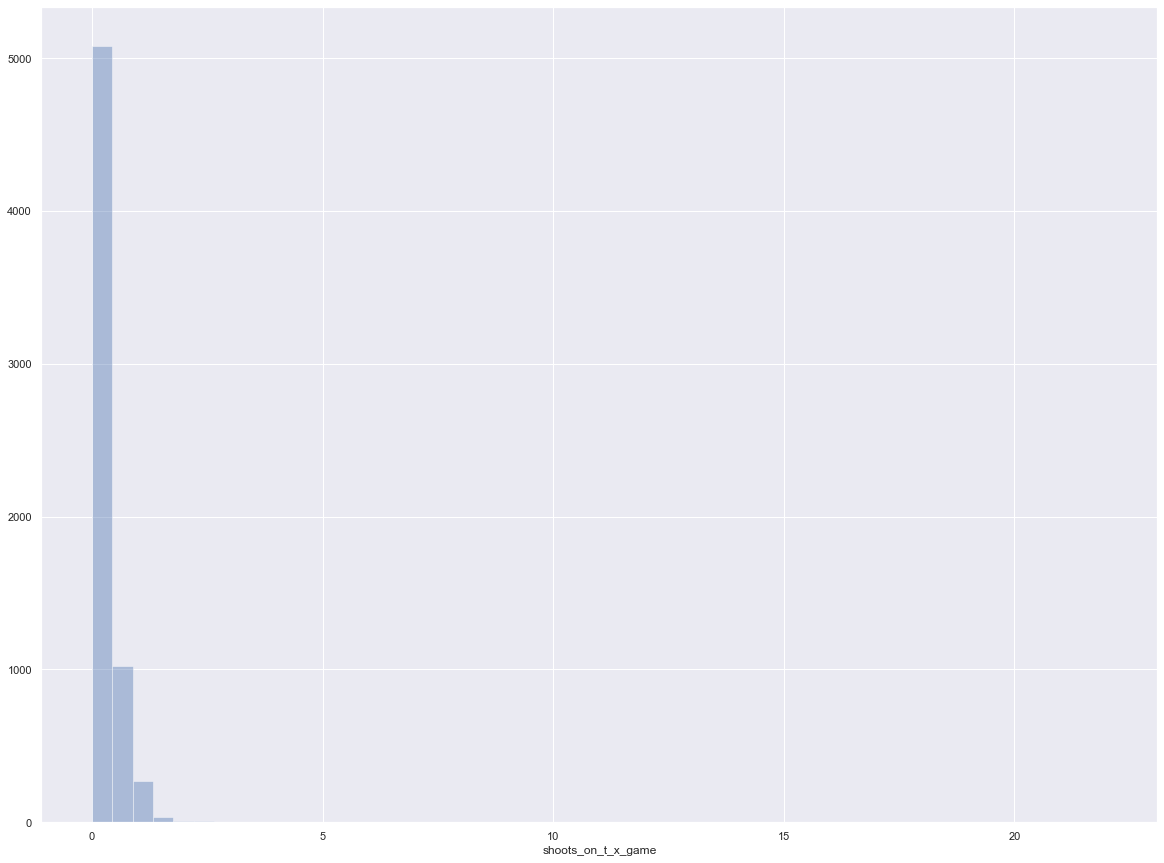

In [37]:
plt.figure(figsize=(20,15))
sns.distplot(data_alta_corr['shoots_on_t_x_game'], kde = False)

plt.savefig("D:\Jesus\BootCampThe_Bridge\Clases\Alumno\Entregables\Proyecto_ML\src\data\images/shoots_on_t_x_game.jpg")

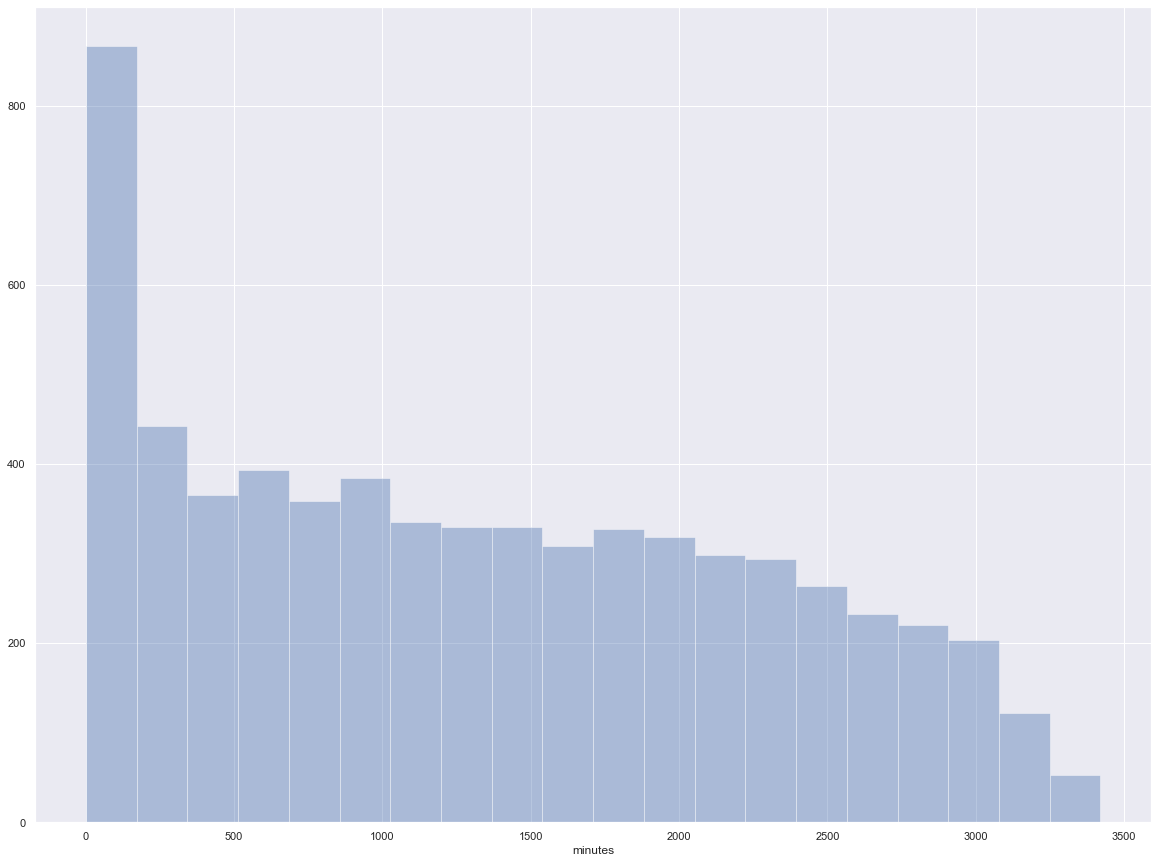

In [38]:
plt.figure(figsize=(20,15))
sns.distplot(data_alta_corr['minutes'], kde = False)

plt.savefig("D:\Jesus\BootCampThe_Bridge\Clases\Alumno\Entregables\Proyecto_ML\src\data\images/minutes.jpg")

In [39]:
data_alta_corr.to_csv("D:\Jesus\BootCampThe_Bridge\Clases\Alumno\Entregables\Proyecto_ML\src\data\processed\Datos_Clasif_corr.csv", sep = ';')

In [40]:
data_alta_corr_norm = data_player_norm.drop(['passes_x_game','squad'], axis = 'columns')

### Guardamos nuestros diferentes sets de entrenamiento y test para usarlos en nuestros modelos. los exportamos para tenerlos disponibles en otros notebooks.

In [41]:
# Set de entrenamiento sin normalizar
func.save_train_sets(path = "D:\Jesus\BootCampThe_Bridge\Clases\Alumno\Entregables\Proyecto_ML\src\data\processed/train_set.npz", 
                                tupla_datos = func.split_train_set(data = data_player, test_prop = 0.2, rand_st = 5, target_name = 'goals'))
# Set de entrenamiento normalizado
func.save_train_sets(path = "D:\Jesus\BootCampThe_Bridge\Clases\Alumno\Entregables\Proyecto_ML\src\data\processed/train_set_norm.npz", 
                                tupla_datos = func.split_train_set(data = data_player_norm, test_prop = 0.2, rand_st = 5, target_name = 'goals'))  
# Set de entrenamiento sin normalizar y solo con las columnas más correladas
func.save_train_sets(path = "D:\Jesus\BootCampThe_Bridge\Clases\Alumno\Entregables\Proyecto_ML\src\data\processed/train_set_corr.npz", 
                                tupla_datos = func.split_train_set(data = data_alta_corr, test_prop = 0.2, rand_st = 5, target_name = 'goals'))   
# Set de entrenamiento normalizado con alta correlación
func.save_train_sets(path = "D:\Jesus\BootCampThe_Bridge\Clases\Alumno\Entregables\Proyecto_ML\src\data\processed/train_norm_corr.npz", 
                                tupla_datos = func.split_train_set(data = data_alta_corr_norm, test_prop = 0.2, rand_st = 5, target_name = 'goals'))                                                                                          